In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

In [4]:
#Load the sequence data from csv
df = pd.read_csv('I:\DM PROJECT\originaldataset\AEP_hourly.csv')

In [5]:
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [6]:
dataset = df
dataset["Month"] = pd.to_datetime(df["Datetime"]).dt.month
dataset["Year"] = pd.to_datetime(df["Datetime"]).dt.year
dataset["Date"] = pd.to_datetime(df["Datetime"]).dt.date
dataset["Time"] = pd.to_datetime(df["Datetime"]).dt.time
dataset["Week"] = pd.to_datetime(df["Datetime"]).dt.isocalendar().week
dataset["Day"] = pd.to_datetime(df["Datetime"]).dt.day_name()


**Data Time Period**

In [7]:
df['Date'].min(), df['Date'].max()

(datetime.date(2004, 10, 1), datetime.date(2018, 8, 3))

# Visualize the data

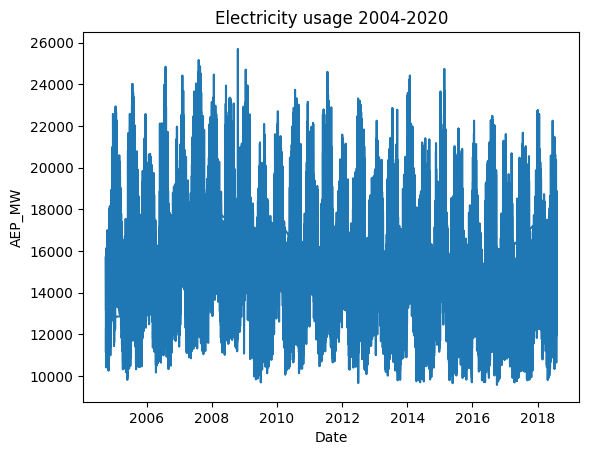

In [8]:
import matplotlib.pyplot as plt

plt.plot(df['Date'], df['AEP_MW'])
plt.title('Electricity usage 2004-2020')
plt.xlabel('Date')
plt.ylabel('AEP_MW')
plt.show()

In [9]:
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=df['Date'], y=df['AEP_MW'], name='AEP_MW'))
# fig.update_layout(showlegend=True, title='Electricity usage 2004-2020')
# fig.show(renderer='colab')


# Data Preprocessing

In [10]:
startdate = pd.to_datetime("2006-12-10").date()
enddate = pd.to_datetime("2010-6-10").date()
train = df.loc[df['Date'] <= startdate]
test = df.loc[df['Date'] > enddate]
train.shape, test.shape

((19218, 8), (71390, 8))

# Data Scaling

In [11]:
scaler = StandardScaler()
scaler = scaler.fit(np.array(train['AEP_MW']).reshape(-1,1))

train['AEP_MW'] = scaler.transform(np.array(train['AEP_MW']).reshape(-1,1))
test['AEP_MW'] = scaler.transform(np.array(test['AEP_MW']).reshape(-1,1))

C:\Users\Administrator\AppData\Local\Temp\ipykernel_15980\282904655.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['AEP_MW'] = scaler.transform(np.array(train['AEP_MW']).reshape(-1,1))
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15980\282904655.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['AEP_MW'] = scaler.transform(np.array(test['AEP_MW']).reshape(-1,1))


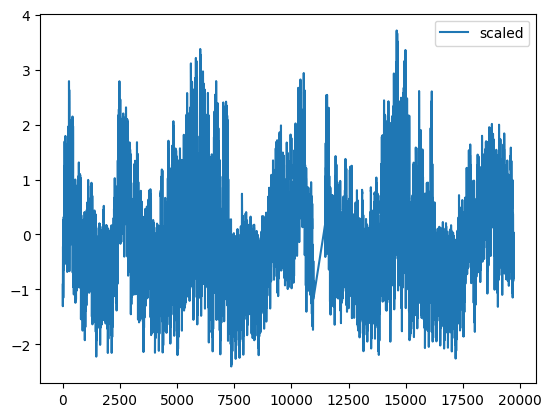

In [12]:
# Visualize scaled data
plt.plot(train['AEP_MW'], label = 'scaled')
plt.legend()
plt.show()

# Create sequences

In [13]:
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    X_out, y_out = [], []
    for i in range(len(X)-time_steps):
        X_out.append(X.iloc[i:(i+time_steps)].values)
        y_out.append(y.iloc[i+time_steps])
    
    return np.array(X_out), np.array(y_out)

X_train, y_train = create_sequences(train[['AEP_MW']], train['AEP_MW'])
X_test, y_test = create_sequences(test[['AEP_MW']], test['AEP_MW'])
print("Training input shape: ", X_train.shape)
print("Testing input shape: ", X_test.shape)

Training input shape:  (19188, 30, 1)
Testing input shape:  (71360, 30, 1)


In [14]:
# set seed to regenerate same sequence of random numbers. 
np.random.seed(21)
tf.random.set_seed(21)

# Build a model

In [15]:
print(X_train.shape[1])

30


In [16]:
print(X_train.shape[2])

1


In [17]:
model = Sequential()
model.add(LSTM(128, activation = 'tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.1))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, activation = 'tanh', return_sequences=True))
model.add(Dropout(rate=0.1))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(loss="mean_squared_error",optimizer="adam",metrics=["mse"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 30, 128)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed (TimeDistr  (None, 30, 1)            129       
 ibuted)                                                

In [18]:
history = model.fit(X_train,y_train,epochs=4, batch_size=5000,validation_split=0.1)

Epoch 1/4
4/4 [==============================] - 30s 6s/step - loss: 1.0513 - mse: 1.0513 - val_loss: 0.6301 - val_mse: 0.6301
Epoch 2/4
4/4 [==============================] - 25s 6s/step - loss: 1.0450 - mse: 1.0450 - val_loss: 0.6333 - val_mse: 0.6333
Epoch 3/4
4/4 [==============================] - 23s 5s/step - loss: 1.0440 - mse: 1.0440 - val_loss: 0.6195 - val_mse: 0.6195
Epoch 4/4
4/4 [==============================] - 23s 5s/step - loss: 1.0442 - mse: 1.0442 - val_loss: 0.6305 - val_mse: 0.6305


# Plot Training - Validation loss

In [40]:
# plt.plot(history.history['loss'], label='Training loss')
# plt.plot(history.history['val_loss'], label='Validation loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend();

600/600 [==============================] - 11s 17ms/step
Reconstruction error threshold: 2.4648784337499516


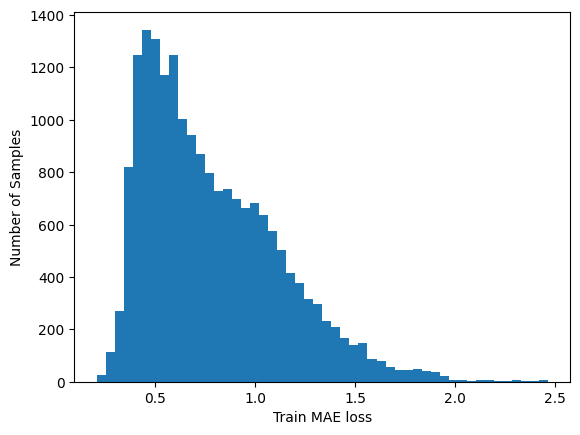

In [20]:
# Mean Absolute Error loss
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

# Set reconstruction error threshold
threshold = np.max(train_mae_loss)

print('Reconstruction error threshold:',threshold)

# Predict Anomalies on test data using threshold

2230/2230 [==============================] - 36s 16ms/step


Text(0, 0.5, 'Number of samples')

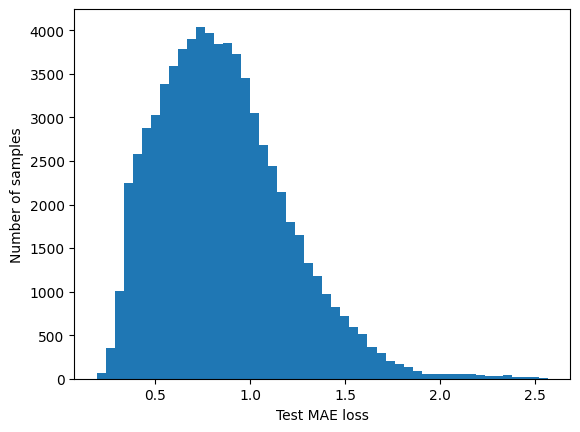

In [21]:
X_test_pred = model.predict(X_test, verbose=1)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples')

In [22]:
anomaly_df = pd.DataFrame(test[TIME_STEPS:])
anomaly_df['loss'] = test_mae_loss
anomaly_df['threshold'] = threshold
anomaly_df['anomaly'] = anomaly_df['loss'] > anomaly_df['threshold']

In [23]:
anomaly_df.head()

,Datetime,AEP_MW,Month,Year,Date,Time,Week,Day,loss,threshold,anomaly
46051,2010-12-30 07:00:00,0.517311,12,2010,2010-12-30,07:00:00,52,Thursday,0.327258,2.464878,False
46052,2010-12-30 08:00:00,0.817133,12,2010,2010-12-30,08:00:00,52,Thursday,0.333967,2.464878,False
46053,2010-12-30 09:00:00,0.890766,12,2010,2010-12-30,09:00:00,52,Thursday,0.345104,2.464878,False
46054,2010-12-30 10:00:00,0.909480,12,2010,2010-12-30,10:00:00,52,Thursday,0.354288,2.464878,False
46055,2010-12-30 11:00:00,0.884257,12,2010,2010-12-30,11:00:00,52,Thursday,0.362422,2.464878,False


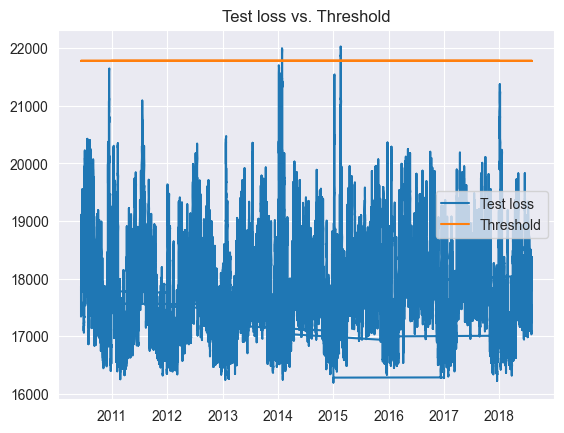

In [39]:
plt.plot(anomaly_df['Date'],scaler.inverse_transform(np.array(anomaly_df['loss']).reshape(-1,1)) , label='Test loss')#scaler.inverse_transform(np.array(anomaly_df['loss']).reshape(-1,1)
plt.plot(anomaly_df['Date'], scaler.inverse_transform(np.array(anomaly_df['threshold']).reshape(-1,1)), label='Threshold')
plt.title('Test loss vs. Threshold')
plt.legend()
plt.show()

In [25]:
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=anomaly_df['loss'], name='Test loss'))
# fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=anomaly_df['threshold'], name='Threshold'))
# fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
# fig.show()

In [42]:
#scaler.inverse_transform(np.array(anomaly_df['anomaly']).reshape(-1,1))
scaler.inverse_transform(np.array(anomaly_df['anomaly']).reshape(-1,1))
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]
anomalies.head()

,Datetime,AEP_MW,Month,Year,Date,Time,Week,Day,loss,threshold,anomaly
89172,2014-01-28 11:00:00,22966.0,1,2014,2014-01-28,11:00:00,5,Tuesday,2.476751,2.464878,True
89173,2014-01-28 12:00:00,22478.0,1,2014,2014-01-28,12:00:00,5,Tuesday,2.491994,2.464878,True
89174,2014-01-28 13:00:00,22153.0,1,2014,2014-01-28,13:00:00,5,Tuesday,2.491927,2.464878,True
89175,2014-01-28 14:00:00,21843.0,1,2014,2014-01-28,14:00:00,5,Tuesday,2.476918,2.464878,True
89183,2014-01-28 22:00:00,22567.0,1,2014,2014-01-28,22:00:00,5,Tuesday,2.476888,2.464878,True


In [43]:
anomalies

,Datetime,AEP_MW,Month,Year,Date,Time,Week,Day,loss,threshold,anomaly
89172,2014-01-28 11:00:00,22966.0,1,2014,2014-01-28,11:00:00,5,Tuesday,2.476751,2.464878,True
89173,2014-01-28 12:00:00,22478.0,1,2014,2014-01-28,12:00:00,5,Tuesday,2.491994,2.464878,True
89174,2014-01-28 13:00:00,22153.0,1,2014,2014-01-28,13:00:00,5,Tuesday,2.491927,2.464878,True
89175,2014-01-28 14:00:00,21843.0,1,2014,2014-01-28,14:00:00,5,Tuesday,2.476918,2.464878,True
89183,2014-01-28 22:00:00,22567.0,1,2014,2014-01-28,22:00:00,5,Tuesday,2.476888,2.464878,True
89184,2014-01-28 23:00:00,22005.0,1,2014,2014-01-28,23:00:00,5,Tuesday,2.513892,2.464878,True
89185,2014-01-29 00:00:00,21579.0,1,2014,2014-01-29,00:00:00,5,Wednesday,2.542172,2.464878,True
89186,2014-01-27 01:00:00,15840.0,1,2014,2014-01-27,01:00:00,5,Monday,2.553789,2.464878,True
89187,2014-01-27 02:00:00,15635.0,1,2014,2014-01-27,02:00:00,5,Monday,2.480497,2.464878,True
97402,2015-02-19 09:00:00,23507.0,2,2015,2015-02-19,09:00:00,8,Thursday,2.477048,2.464878,True


In [28]:
anomalies.shape

(21, 11)

In [29]:
anomaly_df['AEP_MW'] = scaler.inverse_transform(np.array(anomaly_df['AEP_MW']).reshape(-1,1))


In [30]:
anomalies['AEP_MW'] = scaler.inverse_transform(np.array(anomalies['AEP_MW']).reshape(-1,1))

C:\Users\Administrator\AppData\Local\Temp\ipykernel_15980\2354330370.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies['AEP_MW'] = scaler.inverse_transform(np.array(anomalies['AEP_MW']).reshape(-1,1))


In [31]:
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=anomaly_df['AEP_MW'], name='Close price'))
# fig.add_trace(go.Scatter(x=anomalies['Date'], y=anomalies['AEP_MW'], mode='markers', name='Anomaly'))
# fig.update_layout(showlegend=True, title='Detected anomalies')
# fig.show()

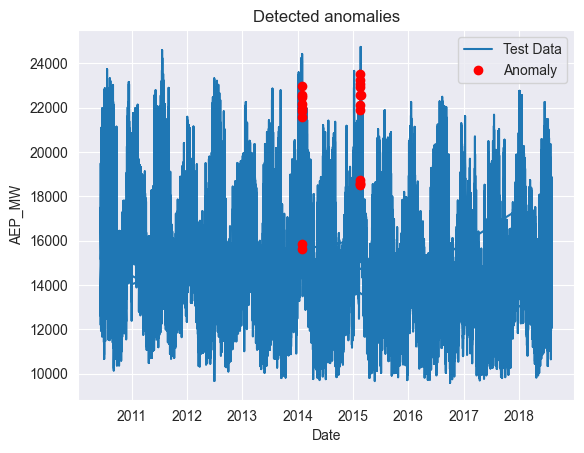

In [41]:
# plot the line chart
plt.plot(anomaly_df['Date'], anomaly_df['AEP_MW'], label='Test Data')

# plot the anomalies as markers
plt.plot(anomalies['Date'], anomalies['AEP_MW'], 'ro', label='Anomaly')

# set title and axis labels
plt.title('Detected anomalies')
plt.xlabel('Date')
plt.ylabel('AEP_MW')

# show the legend
plt.legend()

# display the plot
plt.show()

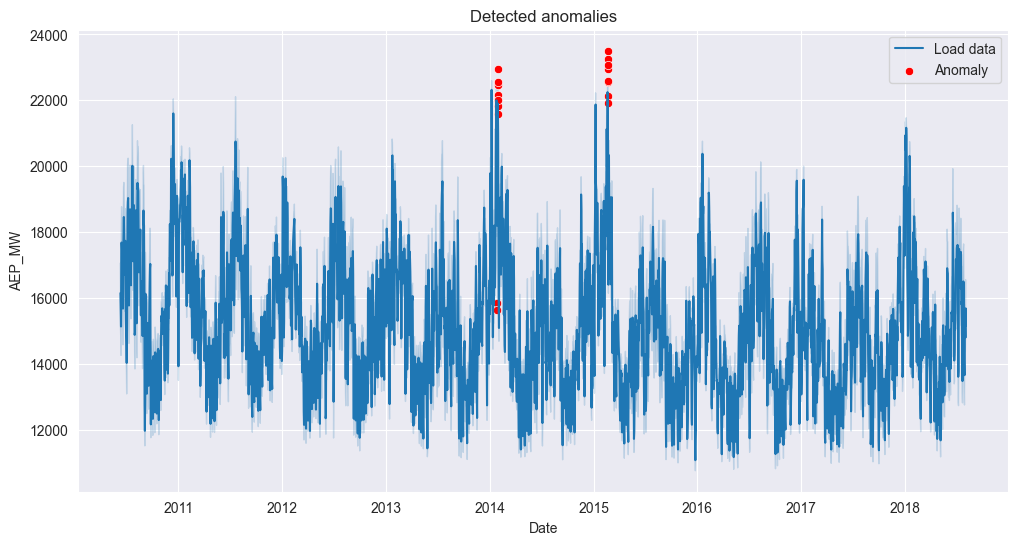

In [33]:
sns.set_style("darkgrid")
plt.figure(figsize=(12, 6))
sns.lineplot(x="Date", y="AEP_MW", data=anomaly_df, label="Load data")
sns.scatterplot(x="Date", y="AEP_MW", data=anomalies, color="red", label="Anomaly")
plt.legend()
plt.title("Detected anomalies")
plt.show()